In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
from scipy.spatial.distance import cdist

In [9]:
from osgeo import gdal

dataset = gdal.Open("l8b30f30clip.tif", gdal.GA_ReadOnly)
array = np.array([dataset.GetRasterBand(1).ReadAsArray().flatten()])
for x in range(2, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(x)
    array = np.append(array,[band.ReadAsArray().flatten()],axis=0)
    
array = np.transpose(array)

In [10]:
!gdalinfo l8b30f30clip.tif

Driver: GTiff/GeoTIFF
Files: l8b30f30clip.tif
       l8b30f30clip.tif.aux.xml
Size is 320, 484
Coordinate System is:
PROJCS["NAD83 / UTM zone 11N",
    GEOGCS["NAD83",
        DATUM["North_American_Datum_1983",
            SPHEROID["GRS 1980",6378137,298.2572221010042,
                AUTHORITY["EPSG","7019"]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG","6269"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433],
        AUTHORITY["EPSG","4269"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-117],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AUTHORITY["EPSG","26911"]]
Origin = (480894.462985141202807,3667501.770068448036909)
Pixel Size = (30.000150431971996,-30.004888571167658)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=PIXEL

In [11]:
len(array)

154880

In [12]:
y=[]
for i in range(len(array)):
    j=[]
    a = (float(array[i][4]) - array[i][3]) / (float(array[i][4]) + array[i][3])
    j.append(a)
    y.append(j)

In [13]:
array=np.append(array,y,axis=1)

In [14]:
array.shape

(154880, 9)

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()
scaler.fit(array.astype(np.float64))
new_array=scaler.transform(array.astype(np.float64))

In [17]:
from sklearn.decomposition import PCA

In [18]:
pca = PCA(n_components=6)
pca.fit(new_array)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [19]:
pca_features=pca.fit_transform(new_array)

In [20]:
pca_features[0]

array([ 2.6781367 ,  0.6656055 ,  0.46970456, -0.75200021, -0.1973811 ,
        0.03468697])

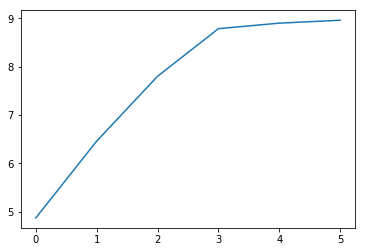

In [21]:
plt.plot(np.cumsum(pca.explained_variance_))
plt.show()

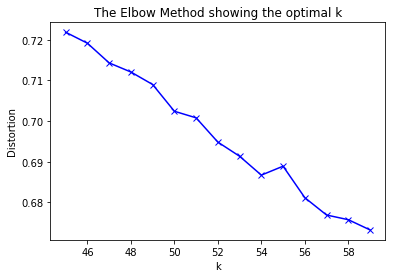

In [32]:
# k means determine k
distortions = []
K = range(45,60)
for k in K:
    kmeanModel = cluster.KMeans(n_clusters=k)
    kmeanModel.fit(pca_features)
    distortions.append(sum(np.min(cdist(pca_features, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / pca_features.shape[0])
    
#Plot the elbow

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [82]:
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(pca_features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [110]:
def plot_clusters(n):
    kmeans = cluster.KMeans(n_clusters=n)
    kmeans.fit(pca_features)
    y=[]
    a = kmeans.labels_
    for i in range(len(array)):
        j=[]
        j.append(a[i])
        y.append(j)
    arr_c=np.append(array,y,axis=1)
    #for i in range(n):
        #'arr_c_'+str(i)=np.array(arr_c)
    for j in range(n):
        arr_c_j = np.array(arr_c)
        for i in range(len(arr_c)):
            if arr_c_j[i][9]==j:
                arr_c_j[i]=1
            else:
                arr_c_j[i]=0
        plt.figure(figsize=(6,5))
        plt.imshow(arr_c_j[:,3].reshape((484,320)), interpolation='nearest', vmin=0,cmap=plt.cm.gist_earth)
        plt.show()
    #return arr_c_j

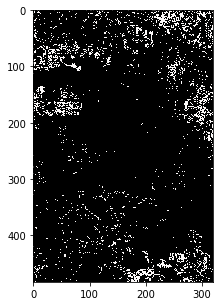

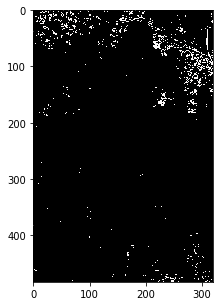

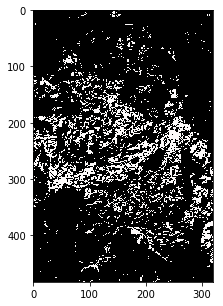

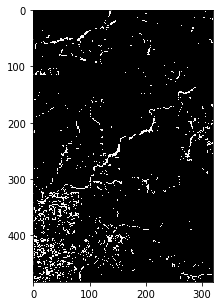

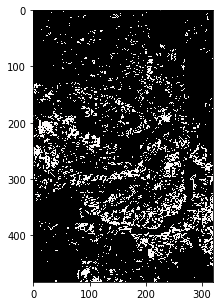

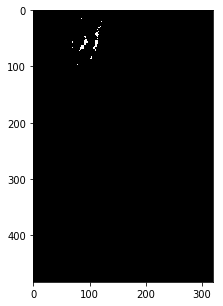

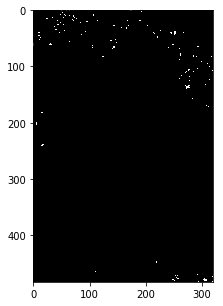

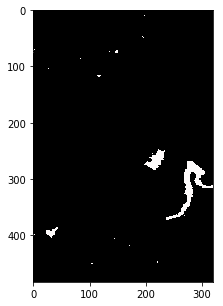

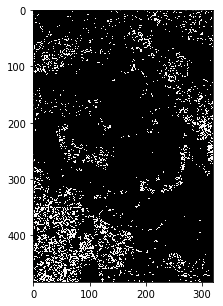

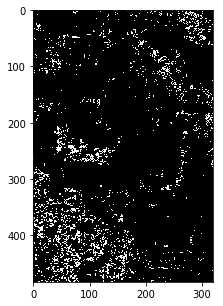

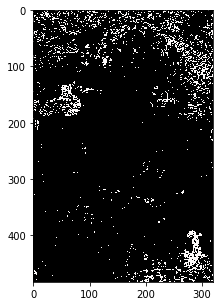

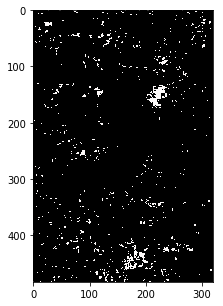

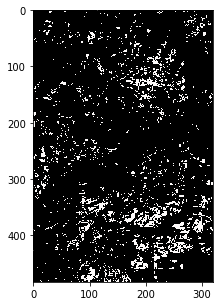

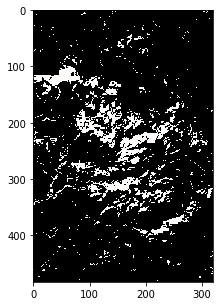

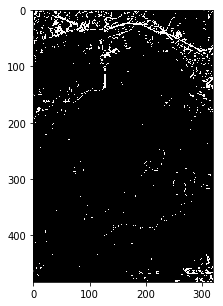

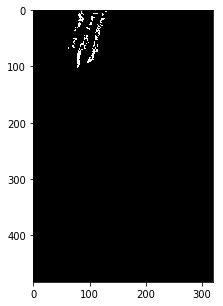

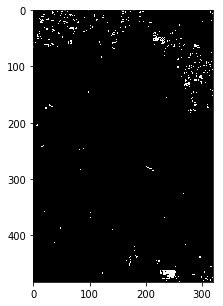

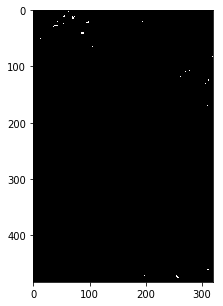

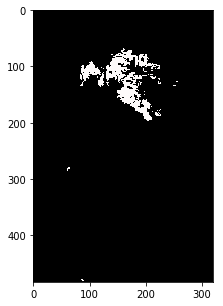

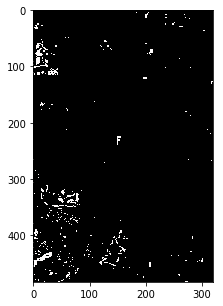

In [111]:
plot_clusters(20)

In [42]:
#band 1-9, no 8
l8 = gdal.Open("l8b30f30clip.tif", gdal.GA_ReadOnly)

In [183]:
driver = gdal.GetDriverByName('GTiff')
filename = 'new.tif'
x_pixels = l8.RasterXSize
y_pixels = l8.RasterYSize

new = driver.Create(
    filename,
    x_pixels,
    y_pixels,
    3,
    gdal.GDT_Float32) 


new.GetRasterBand(1).WriteArray(arr_cluster3_1[:,3].reshape((484,320))
new.GetRasterBand(2).WriteArray(arr_cluster3_1[:,2].reshape((484,320))
new.GetRasterBand(3).WriteArray(arr_cluster3_1[:,1].reshape((484,320))

driver = gdal.GetDriverByName( 'MEM' )
driver2 = gdal.GetDriverByName( 'PNG' )
ds = driver.Create( '', 255, 255, 1, gdal.GDT_Int32)
ds2 = driver.CreateCopy('/tmp/out.png', ds, 0)

#gdal.Translate('out.png', new, format = 'PNG')
new.FlushCache()  # Write to disk.
new = None